<a href="https://colab.research.google.com/github/Thorfast191/YOUR-PANTHEON/blob/main/Hermes/Sentiment_module/sentiment_analysis_using_pytorch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets transformers datasets torch numpy scikit-learn spacy nlpaug

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!pip install --upgrade transformers

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dependencies

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

import spacy
import nlpaug.augmenter.word as naw
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Load and Process the GoEmotions Dataset

In [7]:
# Load a small subset of the GoEmotions (simplified) dataset
go_emo = load_dataset("go_emotions", "simplified",
                        split={'train': 'train[:4000]',
                               'validation': 'validation[:500]',
                               'test': 'test[:500]'})


# Define fine-grained emotion labels
emotion_labels = go_emo["train"].features["labels"].feature.names

# Mapping from each fine-grained emotion to a sentiment category
emotion_to_category = {
    "admiration": "positive",
    "amusement": "positive",
    "approval": "positive",
    "caring": "positive",
    "desire": "positive",
    "excitement": "positive",
    "gratitude": "positive",
    "joy": "positive",
    "love": "positive",
    "optimism": "positive",
    "pride": "positive",
    "anger": "negative",
    "annoyance": "negative",
    "disappointment": "negative",
    "disapproval": "negative",
    "disgust": "negative",
    "embarrassment": "negative",
    "fear": "negative",
    "grief": "negative",
    "nervousness": "negative",
    "remorse": "negative",
    "sadness": "negative",
    "confusion": "neutral",
    "curiosity": "neutral",
    "neutral": "neutral",
    "realization": "neutral",
    "relief": "neutral",
    "surprise": "neutral"
}

# Function to convert list of label indices to a single sentiment using majority vote
def get_sentiment(label_indices):
    sentiments = [emotion_to_category[emotion_labels[i]] for i in label_indices]
    pos = sentiments.count("positive")
    neg = sentiments.count("negative")
    neu = sentiments.count("neutral")
    if pos >= neg and pos >= neu:
        return 2  # positive
    elif neg >= pos and neg >= neu:
        return 0  # negative
    else:
        return 1  # neutral

# Process a dataset split to extract texts and sentiment labels
def process_split(split):
    texts = split["text"]
    sentiments = [get_sentiment(lbl) for lbl in split["labels"]]
    return texts, sentiments

train_texts, train_sentiments = process_split(go_emo["train"])
val_texts, val_sentiments = process_split(go_emo["validation"])
test_texts, test_sentiments = process_split(go_emo["test"])


print("Train distribution:", Counter(train_sentiments))
print("Validation distribution:", Counter(val_sentiments))
print("Test distribution:", Counter(test_sentiments))

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define intensifiers
INTENSIFIERS = {'very', 'extremely', 'absolutely', 'highly', 'completely', 'totally', 'utterly', 'really'}

def extract_intensity_features(text):
    doc = nlp(text)
    features = {
        'num_intensifiers': 0,
        'max_intensity': 1.0,
        'weighted_intensity': 1.0
    }
    for token in doc:
        if token.text.lower() in INTENSIFIERS:
            features['num_intensifiers'] += 1
            intensity = 1.5 if token.text.lower() == 'very' else 1.3
            features['max_intensity'] = max(features['max_intensity'], intensity)
            features['weighted_intensity'] *= intensity
    return features

# Data augmentation using synonym replacement from nlpaug
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

def augment_text(text):
    # Return the first element of the augmented list (or the original if list is empty)
    augmented_texts = aug.augment(text)
    return augmented_texts[0] if augmented_texts else text

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train distribution: Counter({2: 1588, 1: 1553, 0: 859})
Validation distribution: Counter({2: 199, 1: 190, 0: 111})
Test distribution: Counter({1: 207, 2: 174, 0: 119})


# Create a Custom PyTorch Dataset

In [8]:
class GoEmoDataset(Dataset):
    def __init__(self, texts, sentiments, tokenizer, max_length=128, augment=False, include_intensity=False):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment
        self.include_intensity = include_intensity

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Apply augmentation if enabled
        if self.augment:
            text = augment_text(text)
        # Extract intensity features if enabled
        intensity_features = extract_intensity_features(text) if self.include_intensity else None

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.sentiments[idx], dtype=torch.long)
        if self.include_intensity:
            # Convert intensity features dictionary to tensor
            intensity_tensor = torch.tensor([intensity_features['num_intensifiers'],
                                               intensity_features['max_intensity'],
                                               intensity_features['weighted_intensity']], dtype=torch.float)
            item["intensity_features"] = intensity_tensor
        return item

# Create Datasets and DataLoaders

In [9]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Create dataset objects
train_dataset = GoEmoDataset(train_texts, train_sentiments, tokenizer, augment=True, include_intensity=True)
val_dataset   = GoEmoDataset(val_texts, val_sentiments, tokenizer, augment=False, include_intensity=True)
test_dataset  = GoEmoDataset(test_texts, test_sentiments, tokenizer, augment=False, include_intensity=True)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

# Model Setup

In [10]:
class DistilBertCustom(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        # Add 1 hidden layer with dropout
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768 + 3, 256),  # Hidden layer
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 3)         # Output layer
        )

    def forward(self, input_ids, attention_mask, intensity_features):
        outputs = self.distilbert(input_ids, attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        combined = torch.cat([hidden_state, intensity_features], dim=1)
        return self.classifier(combined)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= DistilBertCustom().to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


# Training and Evaluation Functions

In [11]:
from tqdm.notebook import tqdm

def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training Batches"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        intensity_features = batch["intensity_features"].to(device) # Fetch intensity features from the batch
        # Pass intensity_features to the model's forward method
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, intensity_features=intensity_features)

        loss_fct = torch.nn.CrossEntropyLoss() # Use CrossEntropyLoss to calculate loss
        loss = loss_fct(outputs, labels) # Calculate loss using model outputs and labels

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            intensity_features = batch["intensity_features"].to(device)  # Add this line

            outputs = model(  # Modified forward call
                input_ids=input_ids,
                attention_mask=attention_mask,
                intensity_features=intensity_features
            )

            preds = torch.argmax(outputs, dim=1)  # Remove .logits
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# Training Loop

In [12]:
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, device)
    val_acc = evaluate(model, val_loader, device)  # Now works correctly
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}", flush=True)


Training Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.8383 | Val Accuracy: 0.7180


Training Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.6406 | Val Accuracy: 0.7520


Training Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.5577 | Val Accuracy: 0.7420


# Save And Load Model Func

In [14]:
#%% Define Separate Paths
model_save_path = "/content/drive/MyDrive/Hermes/saved_models"
tokenizer_save_path = "/content/drive/MyDrive/Hermes/saved_tokenizers"

# Create directories if they don't exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tokenizer_save_path, exist_ok=True)

#%% Modified Save Function
def save_separate(model, tokenizer):
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        # 'model_config': model.config
    }, os.path.join(model_save_path, "distilbert_custom_model.pth"))

    # Save tokenizer
    tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Model saved to {model_save_path}")
    print(f"Tokenizer saved to {tokenizer_save_path}")

# Save after training
save_separate(model, tokenizer)

#%% Modified Load Function
def load_separate(device):
    # Load model
    model_checkpoint = torch.load(os.path.join(model_save_path, "distilbert_custom_model.pth"))
    loaded_model = DistilBertCustom().to(device)
    loaded_model.load_state_dict(model_checkpoint['model_state_dict'])

    # Load tokenizer
    loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

    print("Successfully loaded from separate paths!")
    return loaded_model, loaded_tokenizer

# Load the model and tokenizer
loaded_model, loaded_tokenizer = load_separate(device)

#%% Verify Path Structure
!tree -d "/content/drive/MyDrive/Hermes"  # Verify directory structure in Colab

Model saved to /content/drive/MyDrive/Hermes/saved_models
Tokenizer saved to /content/drive/MyDrive/Hermes/saved_tokenizers
Successfully loaded from separate paths!
/bin/bash: line 1: tree: command not found


# Final Evaluation on the Test Set

In [25]:
def predict_interactive(model, tokenizer):
    text = input("Enter text to analyze: ")

    # Extract features
    intensity = extract_intensity_features(text)

    # Create tensor with proper syntax
    intensity_tensor = torch.tensor(
        [
            [
                intensity['num_intensifiers'],
                intensity['max_intensity'],
                intensity['weighted_intensity']
            ]
        ],
        dtype=torch.float
    ).to(device)

    # Tokenize
    inputs = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            intensity_features=intensity_tensor
        )

    probs = torch.softmax(outputs, dim=1)[0]
    pred = torch.argmax(outputs).item()

    print("\nPrediction Probabilities:")
    for i, (label, prob) in enumerate(zip(["negative", "neutral", "positive"], probs)):
        print(f"{label}: {prob*100:.1f}%")

    print(f"\nFinal Prediction: {['negative', 'neutral', 'positive'][pred]}")

predict_interactive(loaded_model, loaded_tokenizer)

Enter text to analyze: I am not feeling well, i will not go to school tommorrow but maybe i will be fine by tonight, let see what happens

Prediction Probabilities:
negative: 36.1%
neutral: 18.1%
positive: 45.8%

Final Prediction: positive


In [26]:
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7200


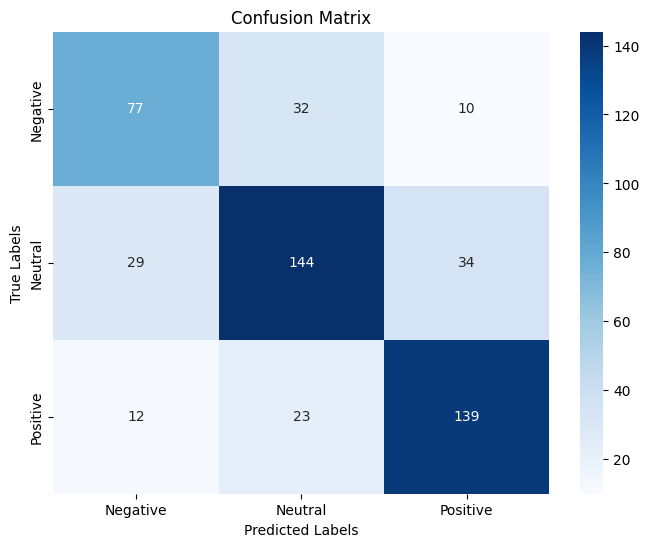


Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.65      0.65       119
     Neutral       0.72      0.70      0.71       207
    Positive       0.76      0.80      0.78       174

    accuracy                           0.72       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.72      0.72      0.72       500



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Assuming 'test_sentiments' contains the true labels for your test set
true_labels = test_sentiments

# Get model predictions
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        intensity_features = batch['intensity_features'].to(device)
        outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask, intensity_features=intensity_features)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to NumPy

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],  # Updated labels
            yticklabels=['Negative', 'Neutral', 'Positive'])  # Updated labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Neutral', 'Positive']))  # Updated labels